In [6]:
# Import modules
import pandas as pd
import numpy as np
import sklearn
import torch
from torch import nn
from sklearn.model_selection import train_test_split
torch.__version__

'2.2.2'

In [7]:
# Load the dataset and review the first 100 characters
with open("the-verdict.txt", "r",encoding="utf-8") as f:
    raw_text = f.read()
print("Length of text:", len(raw_text))
print(raw_text[:9])

Length of text: 20479
I HAD alw


In [8]:
1+1

2

In [9]:
data = [1,2,3]
tens1 = torch.tensor(data)
print(tens1)

tensor([1, 2, 3])


In [10]:
array = np.array([1,2,3])
print(array)
tens2 = torch.from_numpy(array)
print(tens2)

[1 2 3]
tensor([1, 2, 3])


In [11]:
# Ch 2, p 22 - split text
import re
text = "Hello, world!  This, is a test."
result = re.split(r'([!,.]|\s)', text)
print(result)
result2 = [item for item in result if item.strip()]
print(result2)

['Hello', ',', '', ' ', 'world', '!', '', ' ', '', ' ', 'This', ',', '', ' ', 'is', ' ', 'a', ' ', 'test', '.', '']
['Hello', ',', 'world', '!', 'This', ',', 'is', 'a', 'test', '.']


In [12]:
# Add more puncuation and  --- to the split
text = "Hello, world!  This: -- is a test. Maybe?"
result = re.split(r'([!,.?:]|--|\s)', text)
print(result)
result2 = [item for item in result if item.strip()]
print(result2)

['Hello', ',', '', ' ', 'world', '!', '', ' ', '', ' ', 'This', ':', '', ' ', '', '--', '', ' ', 'is', ' ', 'a', ' ', 'test', '.', '', ' ', 'Maybe', '?', '']
['Hello', ',', 'world', '!', 'This', ':', '--', 'is', 'a', 'test', '.', 'Maybe', '?']


In [13]:
# p24 - Use tokenizer scheme on Wharton text
preprocessed = re.split(r'([!,.?:;"_()\']|--|\s)', raw_text)
preprocessed = [item.strip() for item in preprocessed if item.strip()]
print(len(preprocessed))


4690


In [14]:
# Test output of tokenized used on The Verdict  
print(preprocessed[0:30])

['I', 'HAD', 'always', 'thought', 'Jack', 'Gisburn', 'rather', 'a', 'cheap', 'genius', '--', 'though', 'a', 'good', 'fellow', 'enough', '--', 'so', 'it', 'was', 'no', 'great', 'surprise', 'to', 'me', 'to', 'hear', 'that', ',', 'in']


In [15]:
# 2.3 - Create a vocabulary

# Create list of all uniuqe words and sort
all_words   = sorted(set(preprocessed))
vocab_size  = len(all_words)
print(vocab_size)

1130


In [16]:
# Use vocab to create a dictionary
vocab = {token: integer for integer, token in enumerate(all_words)}
for i, item in enumerate(vocab.items()):
    print(item)
    if i > 20:
        break
    

('!', 0)
('"', 1)
("'", 2)
('(', 3)
(')', 4)
(',', 5)
('--', 6)
('.', 7)
(':', 8)
(';', 9)
('?', 10)
('A', 11)
('Ah', 12)
('Among', 13)
('And', 14)
('Are', 15)
('Arrt', 16)
('As', 17)
('At', 18)
('Be', 19)
('Begin', 20)
('Burlington', 21)


In [17]:
# p 27 - Make simple tokenizer Class
class SimpleTokenV1:
    
    def __init__(self, vocab):
        self.str_to_int = vocab # stores the vocab dictionary
        self.int_to_str = {integer: string for string, integer in vocab.items()} # reverse dictionary (token IDS to text tokens)

    def encode(self, text):
        preprocessed = re.split(r'([!,.?:;"()\']|--|\s)', text)
        preprocessed = [item for item in preprocessed if item.strip()]
        ids = [self.str_to_int[token] for token in preprocessed]
        return ids # return the token IDs

    def decoder(self, ids):  # Converts token IDs back to text
        text = " ".join([self.int_to_str[i] for i in ids])
        text = re.sub(r'\s+([!,.?:;"_()\'])', r'\1', text)
        return text
    

In [18]:
# Test the tokenizer
tokenizer = SimpleTokenV1(vocab)
text = """"It's the last he painted, you know," 
Mrs. Gisburn said with pardonable pride."""
ids = tokenizer.encode(text)
print(ids)

[1, 56, 2, 850, 988, 602, 533, 746, 5, 1126, 596, 5, 1, 67, 7, 38, 851, 1108, 754, 793, 7]


In [19]:
# Test the decoder
print(tokenizer.decoder(ids))

" It' s the last he painted, you know," Mrs. Gisburn said with pardonable pride.


In [20]:
# Need to account for words not in the vocab
all_tokens = sorted(list(set(preprocessed)))
all_tokens.extend(["<|endoftext|>","<|unk|>"])
vocab = {token: integer for integer, token in enumerate(all_tokens)}
print(len(vocab.items()))

1132


In [21]:
# Confirm that new characters are in the vocab
for i, item in enumerate(list(vocab.items())[-5:]):
    print(item)

('younger', 1127)
('your', 1128)
('yourself', 1129)
('<|endoftext|>', 1130)
('<|unk|>', 1131)


In [22]:
# p 31 - Adjust tokenizer class to reflect UNK token
class SimpleTokenizerV2:
    
    def __init__(self, vocab):
        self.str_to_int = vocab # stores the vocab dictionary
        self.int_to_str = {integer: string for string, integer in vocab.items()} # reverse dictionary (token IDS to text tokens)

    def encode(self, text):
        preprocessed = re.split(r'([,.:;?_!"()\']|--|\s)', text)
        preprocessed = [item.strip() for item in preprocessed if item.strip()]

        # Account for words not in the vocab
        preprocessed = [token if token in self.str_to_int else "<|unk|>" for token in preprocessed]

        ids = [self.str_to_int[token] for token in preprocessed]
        return ids # return the token IDs

    def decoder(self, ids):  # Converts token IDs back to text
        text = " ".join([self.int_to_str[i] for i in ids])
        text = re.sub(r'\s+([,.:;?!"()\'])', r'\1', text)
        return text

In [23]:
# Test the tokenizer adjusted for unknown words
text1 = "Hello, do you like tea?"
text2 = "In the sunlit terraces of the palace."
text = " <|endoftext|> ".join((text1, text2))
print(text)

Hello, do you like tea? <|endoftext|> In the sunlit terraces of the palace.


In [24]:
# Get token IDs
tokenizer = SimpleTokenizerV2(vocab)
print(tokenizer.encode(text))

[1131, 5, 355, 1126, 628, 975, 10, 1130, 55, 988, 956, 984, 722, 988, 1131, 7]


In [25]:
# Test the decoder
print(tokenizer.decoder(tokenizer.encode(text)))

<|unk|>, do you like tea? <|endoftext|> In the sunlit terraces of the <|unk|>.


In [26]:
# 2.5 - p 33 - Byte Pair Encoding

In [27]:
from importlib.metadata import version
import tiktoken
print("Tiktoken version:", version("Tiktoken"))

Tiktoken version: 0.8.0


In [28]:
# Instantiate BPE tokenizer
tokenizer = tiktoken.get_encoding("gpt2")

In [29]:
# Encode text to integers
text = ("Hello, do you like tea? <|endoftext]> In the sunlit terraces " 
        "of someunknownPlace.")
integers = tokenizer.encode(text, allowed_special={"<|endoftext|>"})
print(integers)

[15496, 11, 466, 345, 588, 8887, 30, 1279, 91, 437, 1659, 5239, 60, 29, 554, 262, 4252, 18250, 8812, 2114, 286, 617, 34680, 27271, 13]


In [30]:
# Decode integers back to text
strings = tokenizer.decode(integers)
print(strings)

Hello, do you like tea? <|endoftext]> In the sunlit terraces of someunknownPlace.


In [31]:
# Use BPE on The Verdict
with open("the-verdict.txt", "r", encoding="utf-8") as f:
    raw_text = f.read()

enc_text = tokenizer.encode(raw_text)
print(len(enc_text))
print(type(enc_text))

5145
<class 'list'>


In [32]:
# Take sample of encoded text
enc_sample = enc_text[50:]
context_size = 4
x = enc_sample[:context_size]
y = enc_sample[1:context_size+1]
print(f"x:  {x}")
print(f"y:      {y}")

x:  [290, 4920, 2241, 287]
y:      [4920, 2241, 287, 257]


In [33]:
#  Test print integers
for i in range(1,context_size+1):
    context = enc_sample[:i]
    desired = enc_sample[i]
    print(context, "------->", desired)

[290] -------> 4920
[290, 4920] -------> 2241
[290, 4920, 2241] -------> 287
[290, 4920, 2241, 287] -------> 257


In [34]:
# Convert back to text using decoder
for i in range(1,context_size+1):
    context = enc_sample[:i]
    desired = enc_sample[i]
    print(tokenizer.decode(context), "------->", tokenizer.decode([desired]))

 and ------->  established
 and established ------->  himself
 and established himself ------->  in
 and established himself in ------->  a


In [35]:
# Build dataset Class   
import torch
from torch.utils.data import Dataset, DataLoader

class GPTDatasetV1(Dataset):
    def __init__(self, txt, tokenizer, max_length, stride):
        self.input_ids = []
        self.target_ids = []

        token_ids = tokenizer.encode(txt) # Tokenize the entire text
        
        # Uses overlapping chunks of max_length tokens
        for i in range(0, len(token_ids) - max_length, stride):
            input_chunk = token_ids[i:i+max_length]
            target_chunk = token_ids[i+1:i+max_length+1]
            self.input_ids.append(torch.tensor(input_chunk))
            self.target_ids.append(torch.tensor(target_chunk)) 

    # Returns total number of rows in the dataset
    def __len__(self):
        return len(self.input_ids)
    
    # Returns a single row of the dataset
    def __getitem__(self, idx):
        return self.input_ids[idx], self.target_ids[idx]

In [36]:
# Dataloader

def create_dataloader_v1(txt,batch_size=4,max_length=256,stride=128, shuffle=True, drop_last=True, num_workers=0):
    tokenizer = tiktoken.get_encoding("gpt2") # Instantiate BPE tokenizer
    dataset = GPTDatasetV1(txt, tokenizer, max_length, stride) # Creates dataset
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                              shuffle=shuffle, drop_last=drop_last, # drop_last=True to drop the last incomplete batch
                                                num_workers=num_workers) # num_workers=0 to use single process
    return dataloader

In [37]:
# Test dataloader with batch size of 1

dataloader = create_dataloader_v1(raw_text, batch_size=1, max_length=4, stride=1, shuffle=False)
data_iter = iter(dataloader)
first_batch = next(data_iter)
print(first_batch)

[tensor([[  40,  367, 2885, 1464]]), tensor([[ 367, 2885, 1464, 1807]])]


In [38]:
# Fetch another batch
second_batch = next(data_iter)
print(second_batch)

[tensor([[ 367, 2885, 1464, 1807]]), tensor([[2885, 1464, 1807, 3619]])]


In [39]:
# Test with larger batch size and stride, so no overlap
dataloader = create_dataloader_v1(raw_text, batch_size=8, max_length=4, stride=4, shuffle=False)

data_iter = iter(dataloader)
inputs,targets = next(data_iter)
print("Inputs:\n",inputs)
print("\nTargets:\n",targets)

Inputs:
 tensor([[   40,   367,  2885,  1464],
        [ 1807,  3619,   402,   271],
        [10899,  2138,   257,  7026],
        [15632,   438,  2016,   257],
        [  922,  5891,  1576,   438],
        [  568,   340,   373,   645],
        [ 1049,  5975,   284,   502],
        [  284,  3285,   326,    11]])

Targets:
 tensor([[  367,  2885,  1464,  1807],
        [ 3619,   402,   271, 10899],
        [ 2138,   257,  7026, 15632],
        [  438,  2016,   257,   922],
        [ 5891,  1576,   438,   568],
        [  340,   373,   645,  1049],
        [ 5975,   284,   502,   284],
        [ 3285,   326,    11,   287]])


In [40]:
# 2.7 (p41) - Create token embeddings from token IDs

# Sample input layer
input_ids = torch.tensor([2,3,5,1])

vocab_size = 6
output_dim = 3

torch.manual_seed(123)
embedding_layer = nn.Embedding(vocab_size, output_dim)
print(embedding_layer.weight)

print(embedding_layer(input_ids))

Parameter containing:
tensor([[ 0.3374, -0.1778, -0.1690],
        [ 0.9178,  1.5810,  1.3010],
        [ 1.2753, -0.2010, -0.1606],
        [-0.4015,  0.9666, -1.1481],
        [-1.1589,  0.3255, -0.6315],
        [-2.8400, -0.7849, -1.4096]], requires_grad=True)
tensor([[ 1.2753, -0.2010, -0.1606],
        [-0.4015,  0.9666, -1.1481],
        [-2.8400, -0.7849, -1.4096],
        [ 0.9178,  1.5810,  1.3010]], grad_fn=<EmbeddingBackward0>)


In [41]:
# 2.8 (p43) - Need to add posistional encoding to the token id embeddings
vocab_size = 50257
output_dim = 256
token_embedding_layer = torch.nn.Embedding(vocab_size, output_dim)


In [42]:
# Example
max_length = 4
dataloader = create_dataloader_v1(raw_text, batch_size=8, max_length=max_length, stride=max_length, shuffle=False)

data_iter = iter(dataloader)
inputs, targets = next(data_iter)
print("Token IDs:\n", inputs)
print("\nInputs shape:\n", inputs.shape) 
print(type(inputs)) 
print(type(targets)) 

Token IDs:
 tensor([[   40,   367,  2885,  1464],
        [ 1807,  3619,   402,   271],
        [10899,  2138,   257,  7026],
        [15632,   438,  2016,   257],
        [  922,  5891,  1576,   438],
        [  568,   340,   373,   645],
        [ 1049,  5975,   284,   502],
        [  284,  3285,   326,    11]])

Inputs shape:
 torch.Size([8, 4])
<class 'torch.Tensor'>
<class 'torch.Tensor'>


In [43]:
# Embed token IDs into 256-dimensional vectors
token_embeddings = token_embedding_layer(inputs)
print(token_embeddings.shape)

torch.Size([8, 4, 256])


In [44]:
# Absolute embedding position
context_length = max_length
pos_embedding_layer = nn.Embedding(context_length, output_dim)
pos_embeddings = pos_embedding_layer(torch.arange(context_length))
print(pos_embeddings.shape)
print(pos_embeddings)


torch.Size([4, 256])
tensor([[ 1.7375, -0.5620, -0.6303,  ..., -0.2277,  1.5748,  1.0345],
        [ 1.6423, -0.7201,  0.2062,  ...,  0.4118,  0.1498, -0.4628],
        [-0.4651, -0.7757,  0.5806,  ...,  1.4335, -0.4963,  0.8579],
        [-0.6754, -0.4628,  1.4323,  ...,  0.8139, -0.7088,  0.4827]],
       grad_fn=<EmbeddingBackward0>)


In [45]:
# Combine token and positional embeddings
input_embeddings = token_embeddings + pos_embeddings
print(input_embeddings.shape)
#print(input_embeddings)

torch.Size([8, 4, 256])


In [46]:
# Ch 3 Coding Attention Mechanism (p 50)

In [47]:
# p57 - Simple self-attention mechanism without trainable weights
import torch

# Create a tensor with 3 token embeddings
inputs = torch.tensor(
    [[0.43, 0.15, 0.89], # Your (x^1)
     [0.55, 0.87, 0.66], #  journey (x^2)
     [0.57, 0.85, 0.64],  # starts (x^3)
     [0.22, 0.58, 0.33],  # with (x^4)
     [0.77, 0.25, 0.10],  # one (x^5)
     [0.05, 0.80, 0.55]],  # step (x^6) 
     
)

print(inputs.shape)

torch.Size([6, 3])


In [48]:
query = inputs[1]
print(query)
print(query.shape)

att_scores_2 = torch.empty(inputs.shape[0])
print(att_scores_2)
print(att_scores_2.shape)

for i,x_i in enumerate(inputs):
    print(i,x_i)
    att_scores_2[i] = torch.dot(x_i, query)
print(att_scores_2)

tensor([0.5500, 0.8700, 0.6600])
torch.Size([3])
tensor([0., 0., 0., 0., 0., 0.])
torch.Size([6])
0 tensor([0.4300, 0.1500, 0.8900])
1 tensor([0.5500, 0.8700, 0.6600])
2 tensor([0.5700, 0.8500, 0.6400])
3 tensor([0.2200, 0.5800, 0.3300])
4 tensor([0.7700, 0.2500, 0.1000])
5 tensor([0.0500, 0.8000, 0.5500])
tensor([0.9544, 1.4950, 1.4754, 0.8434, 0.7070, 1.0865])


In [49]:
# Normalize the attention scores
attn_weights_2_tmp = att_scores_2 / att_scores_2.sum()
print("Attention weights:", attn_weights_2_tmp)
print("Sum",attn_weights_2_tmp.sum())   

Attention weights: tensor([0.1455, 0.2278, 0.2249, 0.1285, 0.1077, 0.1656])
Sum tensor(1.0000)


In [50]:
# Use softmax function to normalize the attention scores (p60)
def softmax_naive(x):
    exp_x = torch.exp(x)
    return exp_x / exp_x.sum(dim=0)

attn_weights_2_naive = softmax_naive(att_scores_2)
print("Attention weights:", attn_weights_2_naive)
print("Sum", attn_weights_2_naive.sum())

Attention weights: tensor([0.1385, 0.2379, 0.2333, 0.1240, 0.1082, 0.1581])
Sum tensor(1.)


In [51]:
# Better to use PyTorch's softmax function
attn_weights_2 = torch.softmax(att_scores_2, dim=0)
print("Attention weights:", attn_weights_2)
print("Sum", attn_weights_2.sum())

Attention weights: tensor([0.1385, 0.2379, 0.2333, 0.1240, 0.1082, 0.1581])
Sum tensor(1.)


In [52]:
# Compute context vectors
query = inputs[1]
print(query)

context_vec_2 = torch.zeros(query.shape)
print("Context_vec_2 shape",context_vec_2.shape)

for i, x_i in enumerate(inputs):
    print(i, x_i)
    print(attn_weights_2[i])
    context_vec_2 += attn_weights_2[i] * x_i
print(context_vec_2)

tensor([0.5500, 0.8700, 0.6600])
Context_vec_2 shape torch.Size([3])
0 tensor([0.4300, 0.1500, 0.8900])
tensor(0.1385)
1 tensor([0.5500, 0.8700, 0.6600])
tensor(0.2379)
2 tensor([0.5700, 0.8500, 0.6400])
tensor(0.2333)
3 tensor([0.2200, 0.5800, 0.3300])
tensor(0.1240)
4 tensor([0.7700, 0.2500, 0.1000])
tensor(0.1082)
5 tensor([0.0500, 0.8000, 0.5500])
tensor(0.1581)
tensor([0.4419, 0.6515, 0.5683])


In [53]:
# Context vectors for all queries

In [54]:
attn_scores = torch.empty(6,6)

for i, x_i in enumerate(inputs):
    for j, x_j in enumerate(inputs):
        attn_scores[i,j] = torch.dot(x_i,x_j)

print(attn_scores)

tensor([[0.9995, 0.9544, 0.9422, 0.4753, 0.4576, 0.6310],
        [0.9544, 1.4950, 1.4754, 0.8434, 0.7070, 1.0865],
        [0.9422, 1.4754, 1.4570, 0.8296, 0.7154, 1.0605],
        [0.4753, 0.8434, 0.8296, 0.4937, 0.3474, 0.6565],
        [0.4576, 0.7070, 0.7154, 0.3474, 0.6654, 0.2935],
        [0.6310, 1.0865, 1.0605, 0.6565, 0.2935, 0.9450]])


In [55]:
# Faster way using matrix multiplication
attn_scores = torch.matmul(inputs, inputs.T)
print(attn_scores)

tensor([[0.9995, 0.9544, 0.9422, 0.4753, 0.4576, 0.6310],
        [0.9544, 1.4950, 1.4754, 0.8434, 0.7070, 1.0865],
        [0.9422, 1.4754, 1.4570, 0.8296, 0.7154, 1.0605],
        [0.4753, 0.8434, 0.8296, 0.4937, 0.3474, 0.6565],
        [0.4576, 0.7070, 0.7154, 0.3474, 0.6654, 0.2935],
        [0.6310, 1.0865, 1.0605, 0.6565, 0.2935, 0.9450]])


In [56]:
# Normalize the attention scores
attn_weights = torch.softmax(attn_scores, dim=-1)
print(attn_weights)

tensor([[0.2098, 0.2006, 0.1981, 0.1242, 0.1220, 0.1452],
        [0.1385, 0.2379, 0.2333, 0.1240, 0.1082, 0.1581],
        [0.1390, 0.2369, 0.2326, 0.1242, 0.1108, 0.1565],
        [0.1435, 0.2074, 0.2046, 0.1462, 0.1263, 0.1720],
        [0.1526, 0.1958, 0.1975, 0.1367, 0.1879, 0.1295],
        [0.1385, 0.2184, 0.2128, 0.1420, 0.0988, 0.1896]])


In [57]:
# Compute context vectors
all_context_vecs = torch.matmul(attn_weights, inputs)
print(all_context_vecs)

tensor([[0.4421, 0.5931, 0.5790],
        [0.4419, 0.6515, 0.5683],
        [0.4431, 0.6496, 0.5671],
        [0.4304, 0.6298, 0.5510],
        [0.4671, 0.5910, 0.5266],
        [0.4177, 0.6503, 0.5645]])


In [58]:
# Alt 2 (3.4 p 64) - Implementing the self atttention with trainable weights

In [59]:
x_2 = inputs[1]
print(x_2)
d_in = inputs.shape[1]
print("d_in",d_in)
d_out = 2

tensor([0.5500, 0.8700, 0.6600])
d_in 3


In [60]:

torch.manual_seed(123)
W_query = torch.nn.Parameter(torch.rand(d_in, d_out),requires_grad=False)
print("W_query:", W_query)
W_key = torch.nn.Parameter(torch.rand(d_in, d_out),requires_grad=False)
print("W_key",W_key)
W_value = torch.nn.Parameter(torch.rand(d_in, d_out),requires_grad=False)
print("W_value",W_value)

W_query: Parameter containing:
tensor([[0.2961, 0.5166],
        [0.2517, 0.6886],
        [0.0740, 0.8665]])
W_key Parameter containing:
tensor([[0.1366, 0.1025],
        [0.1841, 0.7264],
        [0.3153, 0.6871]])
W_value Parameter containing:
tensor([[0.0756, 0.1966],
        [0.3164, 0.4017],
        [0.1186, 0.8274]])


In [61]:
# Compute Query, Key, and Value vectors
query_2 = torch.matmul(x_2, W_query)
query_2_v2 = x_2 @ W_query
key_2 = torch.matmul(x_2, W_key)
value_2 = torch.matmul(x_2, W_value)

print("Query:", query_2)
print("Query_v2:", query_2_v2)

Query: tensor([0.4306, 1.4551])
Query_v2: tensor([0.4306, 1.4551])


In [62]:
# Compute all keys and values
keys = torch.matmul(inputs, W_key)
print("Keys:", keys)
print("Keys shape:", keys.shape)
values = torch.matmul(inputs, W_value)
print("Values:", values)
print("Values shape:", values.shape)

Keys: tensor([[0.3669, 0.7646],
        [0.4433, 1.1419],
        [0.4361, 1.1156],
        [0.2408, 0.6706],
        [0.1827, 0.3292],
        [0.3275, 0.9642]])
Keys shape: torch.Size([6, 2])
Values: tensor([[0.1855, 0.8812],
        [0.3951, 1.0037],
        [0.3879, 0.9831],
        [0.2393, 0.5493],
        [0.1492, 0.3346],
        [0.3221, 0.7863]])
Values shape: torch.Size([6, 2])


In [63]:
# Calc attention scores - unnormalized
keys_2 = keys[1]
print("keys_2:", keys_2)
attn_scores_2 = query_2.dot(keys_2)
attn_scores_2_v2 = query_2 @ keys_2
attn_scores_2_v3 = torch.matmul(query_2, keys_2)
print("Attention scores:", attn_scores_2)
print("Attention scores_v2:", attn_scores_2_v2)
print("Attention scores_v3:", attn_scores_2_v3)

keys_2: tensor([0.4433, 1.1419])
Attention scores: tensor(1.8524)
Attention scores_v2: tensor(1.8524)
Attention scores_v3: tensor(1.8524)


In [64]:
# All attention scores
att_scores_2 = query_2 @ keys.T
print("Attention scores:", att_scores_2)

Attention scores: tensor([1.2705, 1.8524, 1.8111, 1.0795, 0.5577, 1.5440])


In [65]:
# Normalize the attention scores
d_k = keys.shape[1]
print(d_k)
attn_weights_2 = torch.softmax(att_scores_2 / (d_k ** 0.5), dim=-1)
print("Attention weights:", attn_weights_2)
print("Attention weights shape:", attn_weights_2.shape)

2
Attention weights: tensor([0.1500, 0.2264, 0.2199, 0.1311, 0.0906, 0.1820])
Attention weights shape: torch.Size([6])


In [66]:
# Single context vector
context_vec_2 = attn_weights_2 @ values
print("Context vector:", context_vec_2)

Context vector: tensor([0.3061, 0.8210])


In [67]:
# Create Class for self-attention mechanism (p 70)

In [68]:
import torch
import torch.nn as nn
class SelfAttention_v1(nn.Module):
    def __init__(self, d_in, d_out):
        super().__init__()
        self.W_query = nn.Parameter(torch.rand(d_in, d_out))
        self.W_key = nn.Parameter(torch.rand(d_in, d_out))
        self.W_value = nn.Parameter(torch.rand(d_in, d_out))

    def forward(self, x):
        query = x @ self.W_query
        keys = x @ self.W_key
        values = x @ self.W_value

        attn_scores = query @ keys.T
        d_k = keys.shape[-1]
        attn_weights = torch.softmax(attn_scores / (d_k ** 0.5), dim=-1)
        context_vec = attn_weights @ values
        return context_vec

In [69]:
# Test the newly created class
torch.manual_seed(123)
sa_v1 = SelfAttention_v1(d_in, d_out)
print(sa_v1(inputs))

tensor([[0.2996, 0.8053],
        [0.3061, 0.8210],
        [0.3058, 0.8203],
        [0.2948, 0.7939],
        [0.2927, 0.7891],
        [0.2990, 0.8040]], grad_fn=<MmBackward0>)


In [70]:
# Make better version using more stable nn.Linear - using diff wt initialization scheme
class SelfAttention_v2(nn.Module):
    def __init__(self, d_in, d_out,qkv_bias=False):
        super().__init__()
        self.W_query = nn.Linear(d_in, d_out,bias=qkv_bias)
        self.W_key = nn.Linear(d_in, d_out,bias=qkv_bias)
        self.W_value = nn.Linear(d_in, d_out,bias=qkv_bias)

    def forward(self, x):
        query = self.W_query(x)
        keys = self.W_key(x)
        values = self.W_value(x)

        attn_scores = query @ keys.T
        d_k = keys.shape[-1]
        attn_weights = torch.softmax(attn_scores / (d_k ** 0.5), dim=-1)
        context_vec = attn_weights @ values
        return context_vec

In [71]:
# Test it
torch.manual_seed(789)
sa_v2 = SelfAttention_v2(d_in, d_out)
print(sa_v2(inputs))

tensor([[-0.0739,  0.0713],
        [-0.0748,  0.0703],
        [-0.0749,  0.0702],
        [-0.0760,  0.0685],
        [-0.0763,  0.0679],
        [-0.0754,  0.0693]], grad_fn=<MmBackward0>)


In [72]:
# 3.5 Hiding future words with Causal Masking (p 74)

In [73]:
# Compute attention weights
queries = sa_v2.W_query(inputs)
keys = sa_v2.W_key(inputs)  
attn_scores = queries @ keys.T
attn_weights = torch.softmax(attn_scores / keys.shape[-1]**0.5, dim=-1)
print(attn_weights)

tensor([[0.1921, 0.1646, 0.1652, 0.1550, 0.1721, 0.1510],
        [0.2041, 0.1659, 0.1662, 0.1496, 0.1665, 0.1477],
        [0.2036, 0.1659, 0.1662, 0.1498, 0.1664, 0.1480],
        [0.1869, 0.1667, 0.1668, 0.1571, 0.1661, 0.1564],
        [0.1830, 0.1669, 0.1670, 0.1588, 0.1658, 0.1585],
        [0.1935, 0.1663, 0.1666, 0.1542, 0.1666, 0.1529]],
       grad_fn=<SoftmaxBackward0>)


In [74]:
# Create mask using tril so values above diagonal are zero
context_length = attn_scores.shape[0]
print(context_length)
mask_simple = torch.tril(torch.ones(context_length, context_length)) 
print(mask_simple)  

6
tensor([[1., 0., 0., 0., 0., 0.],
        [1., 1., 0., 0., 0., 0.],
        [1., 1., 1., 0., 0., 0.],
        [1., 1., 1., 1., 0., 0.],
        [1., 1., 1., 1., 1., 0.],
        [1., 1., 1., 1., 1., 1.]])


In [75]:
# Multiply mask with attention weights
masked_simple = attn_weights * mask_simple
print(masked_simple)

tensor([[0.1921, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.2041, 0.1659, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.2036, 0.1659, 0.1662, 0.0000, 0.0000, 0.0000],
        [0.1869, 0.1667, 0.1668, 0.1571, 0.0000, 0.0000],
        [0.1830, 0.1669, 0.1670, 0.1588, 0.1658, 0.0000],
        [0.1935, 0.1663, 0.1666, 0.1542, 0.1666, 0.1529]],
       grad_fn=<MulBackward0>)


In [76]:
# Renormalize the masked attention weights
rows_sums = masked_simple.sum(dim=-1,keepdim=True)
masked_simple_norm = masked_simple / rows_sums
print(masked_simple_norm)

tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.5517, 0.4483, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.3800, 0.3097, 0.3103, 0.0000, 0.0000, 0.0000],
        [0.2758, 0.2460, 0.2462, 0.2319, 0.0000, 0.0000],
        [0.2175, 0.1983, 0.1984, 0.1888, 0.1971, 0.0000],
        [0.1935, 0.1663, 0.1666, 0.1542, 0.1666, 0.1529]],
       grad_fn=<DivBackward0>)


In [77]:
# More efficient way to do it - use negative infinity before softmax
mask = torch.triu(torch.ones(context_length, context_length),diagonal=1)
masked =attn_scores.masked_fill(mask.bool(), -torch.inf)
print(masked)   

tensor([[0.2899,   -inf,   -inf,   -inf,   -inf,   -inf],
        [0.4656, 0.1723,   -inf,   -inf,   -inf,   -inf],
        [0.4594, 0.1703, 0.1731,   -inf,   -inf,   -inf],
        [0.2642, 0.1024, 0.1036, 0.0186,   -inf,   -inf],
        [0.2183, 0.0874, 0.0882, 0.0177, 0.0786,   -inf],
        [0.3408, 0.1270, 0.1290, 0.0198, 0.1290, 0.0078]],
       grad_fn=<MaskedFillBackward0>)


In [78]:
# Apply softmax to this more efficient mask
attn_weights = torch.softmax(masked / keys.shape[-1]**0.5, dim=-1)
print(attn_weights)

tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.5517, 0.4483, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.3800, 0.3097, 0.3103, 0.0000, 0.0000, 0.0000],
        [0.2758, 0.2460, 0.2462, 0.2319, 0.0000, 0.0000],
        [0.2175, 0.1983, 0.1984, 0.1888, 0.1971, 0.0000],
        [0.1935, 0.1663, 0.1666, 0.1542, 0.1666, 0.1529]],
       grad_fn=<SoftmaxBackward0>)


In [79]:
# Masking with dropout (p 78)
# used (1) after calculating attention weights and (2) after applying attention weights to value vectors

In [80]:
# Create a mask with 50% of values set to zero - simple example
torch.manual_seed(123)
dropout = torch.nn.Dropout(0.5)
example = torch.ones(6,6)
print(dropout(example))

tensor([[2., 2., 2., 2., 2., 2.],
        [0., 2., 0., 0., 0., 0.],
        [0., 0., 2., 0., 2., 0.],
        [2., 2., 0., 0., 0., 2.],
        [2., 0., 0., 0., 0., 2.],
        [0., 2., 0., 0., 0., 0.]])


In [81]:
# Apply dropout to attention weights - actual
torch.manual_seed(123)
print(dropout(attn_weights))

tensor([[2.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.8966, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.6206, 0.0000, 0.0000, 0.0000],
        [0.5517, 0.4921, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.4350, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.3327, 0.0000, 0.0000, 0.0000, 0.0000]],
       grad_fn=<MulBackward0>)


In [82]:
#  Create compact casual attention class
# Need to allow for batch inputs

batch = torch.stack((inputs,inputs),dim=0)
print(batch[0])
print(batch.shape)

tensor([[0.4300, 0.1500, 0.8900],
        [0.5500, 0.8700, 0.6600],
        [0.5700, 0.8500, 0.6400],
        [0.2200, 0.5800, 0.3300],
        [0.7700, 0.2500, 0.1000],
        [0.0500, 0.8000, 0.5500]])
torch.Size([2, 6, 3])


In [83]:
# New class with Causal Masking and Dropout
class CausalAttention(nn.Module):

    def __init__(self, d_in, d_out, context_length, dropout, qkv_bias=False):
        super().__init__()
        self.d_out = d_out
        print("d_out",d_out)
        print("context_length",context_length)
        print("dropout",dropout)
        self.W_query = nn.Linear(d_in, d_out,bias=qkv_bias)
        self.W_key = nn.Linear(d_in, d_out,bias=qkv_bias)
        self.W_value = nn.Linear(d_in, d_out,bias=qkv_bias)

        self.dropout = nn.Dropout(dropout)  # Added dropout layer

        # Self register buffer used to keep buffer tensors and model params on same device (GPU vs CPU)
        self.register_buffer("mask", torch.triu(torch.ones(context_length, context_length),diagonal=1))
        #print("mask",self.mask)

    def forward(self, x):
        b, num_tokens, d_in = x.shape
        print("batch:",b)
        print("num_tokens:",num_tokens)
        print("d_in:",d_in)
        query = self.W_query(x)
        keys = self.W_key(x)
        #print("keys shape",keys.shape)
        #print("keys:",keys)
        values = self.W_value(x)

        attn_scores = query @ keys.transpose(1,2)

        #mask = torch.triu(torch.ones(attn_scores.shape[0], attn_scores.shape[1]),diagonal=1)
        attn_scores.masked_fill_ = (self.mask.bool()[:num_tokens,:num_tokens], -torch.inf)
        #print("attn_scores shape",attn_scores.shape)
        
        d_k = keys.shape[-1]
        attn_weights = torch.softmax(masked / (d_k ** 0.5), dim=-1)
        
        attn_weights = self.dropout(attn_weights)
        
        context_vecs = attn_weights @ values
        return context_vecs

In [84]:
# Test case
torch.manual_seed(123)
context_length = batch.shape[1]
print(context_length)
ca = CausalAttention(d_in, d_out, context_length, 0.0)
context_vecs = ca(batch)
print("context_vecs.shape:", context_vecs.shape)
print("first context_vecs:", context_vecs[0])

6
d_out 2
context_length 6
dropout 0.0
batch: 2
num_tokens: 6
d_in: 3
context_vecs.shape: torch.Size([2, 6, 2])
first context_vecs: tensor([[-0.4519,  0.2216],
        [-0.5695,  0.0343],
        [-0.6141, -0.0377],
        [-0.5642, -0.0717],
        [-0.5490, -0.0906],
        [-0.5291, -0.0961]], grad_fn=<SelectBackward0>)


In [85]:
# Create multi-head attention class (p 84) -- output context vectors are concatenated
class MultiHeadAttentionWrapper(nn.Module):

    def __init__(self, d_in, d_out, context_length, dropout, num_heads, qkv_bias=False):
        super().__init__()

        self.heads = nn.ModuleList([CausalAttention(d_in, d_out, context_length, dropout, qkv_bias) for _ in range(num_heads)])

    def forward(self, x):
        context_vecs = [head(x) for head in self.heads]
        context_vecs = torch.cat(context_vecs, dim=-1)
        return context_vecs

In [86]:
# Test multi-head attention
torch.manual_seed(123)
context_length = batch.shape[1] # Number of tokens
d_in, d_out = 3, 2
mha = MultiHeadAttentionWrapper(d_in, d_out, context_length, 0.0, num_heads=2)
context_vecs = mha(batch)

print(context_vecs)
print("context_vecs.shape",context_vecs.shape)
# First dimension of 2 for batches, second of 6 is num of elements, 4 is 2 output contcext vectors for each of the 2 heads

d_out 2
context_length 6
dropout 0.0
d_out 2
context_length 6
dropout 0.0
batch: 2
num_tokens: 6
d_in: 3
batch: 2
num_tokens: 6
d_in: 3
tensor([[[-0.4519,  0.2216,  0.4772,  0.1063],
         [-0.5695,  0.0343,  0.5668,  0.2819],
         [-0.6141, -0.0377,  0.6008,  0.3481],
         [-0.5642, -0.0717,  0.5462,  0.3445],
         [-0.5490, -0.0906,  0.5318,  0.3359],
         [-0.5291, -0.0961,  0.5093,  0.3362]],

        [[-0.4519,  0.2216,  0.4772,  0.1063],
         [-0.5695,  0.0343,  0.5668,  0.2819],
         [-0.6141, -0.0377,  0.6008,  0.3481],
         [-0.5642, -0.0717,  0.5462,  0.3445],
         [-0.5490, -0.0906,  0.5318,  0.3359],
         [-0.5291, -0.0961,  0.5093,  0.3362]]], grad_fn=<CatBackward0>)
context_vecs.shape torch.Size([2, 6, 4])


In [87]:
# Multi-head attention class (p 86)

class MultiHeadAttention(nn.Module):
    def __init__(self, d_in, d_out, context_length, dropout, num_heads, qkv_bias=False):
        super().__init__()

        # Confirm that d_out is divisible by num_heads
        assert (d_out % num_heads == 0), \
            "d_out must be divisible by num_heads"

        self.d_out = d_out
        self.num_heads = num_heads
        self.head_dim = d_out // num_heads

        self.W_query = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_key = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_value = nn.Linear(d_in, d_out, bias=qkv_bias)

        self.out_proj = nn.Linear(d_out, d_out)
        self.dropout = nn.Dropout(dropout)
        self.register_buffer("mask", torch.triu(torch.ones(context_length, context_length),diagonal=1))

    def forward(self, x):
        b, num_tokens, d_in = x.shape
        keys = self.W_key(x)
        queries = self.W_query(x)
        values = self.W_value(x)

        keys = keys.view(b, num_tokens, self.num_heads, self.head_dim)
        values = values.view(b, num_tokens, self.num_heads, self.head_dim)
        queries = queries.view(b, num_tokens, self.num_heads, self.head_dim)

        keys = keys.transpose(1,2)  
        queries = queries.transpose(1,2)
        values = values.transpose(1,2)

        attn_scores = queries @ keys.transpose(2,3)
        mask_bool = self.mask.bool()[:num_tokens,:num_tokens]

        attn_scores.masked_fill_(mask_bool, -torch.inf)

        attn_weights = torch.softmax(attn_scores / (keys.shape[-1] ** 0.5), dim=-1)
        attn_weights = self.dropout(attn_weights)

        context_vecs = (attn_weights @ values).transpose(1,2)
        context_vecs = context_vecs.contiguous().view(b, num_tokens, self.d_out)
        context_vecs = self.out_proj(context_vecs)
        
        return context_vecs




In [88]:
# Test  
torch.manual_seed(123)
batch_size, context_length, d_in = batch.shape
print("batch_size",batch_size)
print("context_length",context_length)  
print("d_in",d_in)

mha = MultiHeadAttention(d_in, d_out, context_length, 0.0, num_heads=2)
context_vecs = mha(batch)
print(context_vecs)
print("context_vecs.shape", context_vecs.shape)

batch_size 2
context_length 6
d_in 3
tensor([[[0.3190, 0.4858],
         [0.2943, 0.3897],
         [0.2856, 0.3593],
         [0.2693, 0.3873],
         [0.2639, 0.3928],
         [0.2575, 0.4028]],

        [[0.3190, 0.4858],
         [0.2943, 0.3897],
         [0.2856, 0.3593],
         [0.2693, 0.3873],
         [0.2639, 0.3928],
         [0.2575, 0.4028]]], grad_fn=<ViewBackward0>)
context_vecs.shape torch.Size([2, 6, 2])


In [89]:
# TEST
x = torch.tensor([[1, 2, 3], 
                  [4, 5, 6]])
print(x)
print(x.shape)

tensor([[1, 2, 3],
        [4, 5, 6]])
torch.Size([2, 3])


In [90]:
x_trans = x.transpose(0,1)
print(x_trans)
print(x_trans.shape)

tensor([[1, 4],
        [2, 5],
        [3, 6]])
torch.Size([3, 2])


In [91]:
x_view = x.view(3,2)
print(x_view)

tensor([[1, 2],
        [3, 4],
        [5, 6]])


In [92]:
# Multiply
x_mm = x @ x.T
print(x_mm)

tensor([[14, 32],
        [32, 77]])


In [93]:
# Ch 4 - Coding an LLM Architecture (p 95)

In [94]:
GPT_CONFIG_124M = {
    "vocab_size": 50257,  # Same as BPE vocab size
    "context_length": 1024, # Max num of input tokens
    "emb_dim": 768, # Embedding size for each token
    "n_heads": 4,  # Num of attention heads in each multi-head attention layer
    "n_layers": 12, # Num of transformer blocks
    "drop_rate": 0.1,  # 0.1 means 10% dropped
    "qkv_bias": False    # Whether to add a learnable bias to the query, key, and value projections
}

In [95]:
import torch
import torch.nn as nn

class DummyGPTModel(nn.Module):
    def __init__(self, cfg):
        super().__init__()

        self.tok_emb = nn.Embedding(cfg["vocab_size"], cfg["emb_dim"])
        self.pos_emb = nn.Embedding(cfg["context_length"], cfg["emb_dim"])
        self.drop_emb = nn.Dropout(cfg["drop_rate"])
        self.trf_blocks = nn.Sequential(
            *[DummyTransformerBlock(cfg) for _ in range(cfg["n_layers"])]
        )
        self.final_norm = DummyLayerNorm(cfg["emb_dim"])
        self.out_head = nn.Linear(cfg["emb_dim"], cfg["vocab_size"],bias=False)


    def forward(self, in_idx):
        batch_size, seq_len = in_idx.shape
        tok_embeds = self.tok_emb(in_idx)
        pos_embeds = self.pos_emb(torch.arange(seq_len, device=in_idx.device))

        x = tok_embeds + pos_embeds
        x = self.drop_emb(x)
        x = self.trf_blocks(x)
        x = self.final_norm(x)
        logits = self.out_head(x)
        return logits



class DummyTransformerBlock(nn.Module):
    def __init__(self, cfg):
        super().__init__()

    def forward(self, x):
        return x
class DummyLayerNorm(nn.Module):
    def __init__(self, normalized_shape, eps=1e-5):
        super().__init__()
    def forward(self, x):
        return x

In [96]:
# Create small sample text to run through the model
import tiktoken
batch = []
txt1 = "Every effort moves you"
txt2 = "Every day holds a"

batch.append(torch.tensor(tokenizer.encode(txt1)))
batch.append(torch.tensor(tokenizer.encode(txt2)))
batch = torch.stack(batch, dim=0)
print(batch)

tensor([[6109, 3626, 6100,  345],
        [6109, 1110, 6622,  257]])


In [97]:
# Initialize the model and feed it text
torch.manual_seed(123)
model = DummyGPTModel(GPT_CONFIG_124M)
logits = model(batch)
print("Output shape:", logits.shape)
print("Logits:", logits)

Output shape: torch.Size([2, 4, 50257])
Logits: tensor([[[-0.9289,  0.2748, -0.7557,  ..., -1.6070,  0.2702, -0.5888],
         [-0.4476,  0.1726,  0.5354,  ..., -0.3932,  1.5285,  0.8557],
         [ 0.5680,  1.6053, -0.2155,  ...,  1.1624,  0.1380,  0.7425],
         [ 0.0448,  2.4787, -0.8843,  ...,  1.3219, -0.0864, -0.5856]],

        [[-1.5474, -0.0542, -1.0571,  ..., -1.8061, -0.4494, -0.6747],
         [-0.8422,  0.8243, -0.1098,  ..., -0.1434,  0.2079,  1.2046],
         [ 0.1355,  1.1858, -0.1453,  ...,  0.0869, -0.1590,  0.1552],
         [ 0.1666, -0.8138,  0.2307,  ...,  2.5035, -0.3055, -0.3083]]],
       grad_fn=<UnsafeViewBackward0>)


In [98]:
# Test exampple of a NN layer
torch.manual_seed(123)
batch_example = torch.rand(2, 5)
print("batch example",batch_example)
layer = nn.Sequential(nn.Linear(5, 6), nn.ReLU())
out = layer(batch_example)
print(out)

batch example tensor([[0.2961, 0.5166, 0.2517, 0.6886, 0.0740],
        [0.8665, 0.1366, 0.1025, 0.1841, 0.7264]])
tensor([[0.0000, 0.0000, 0.4091, 0.6587, 0.3914, 0.0000],
        [0.0000, 0.0000, 0.1902, 0.3182, 0.6486, 0.0000]],
       grad_fn=<ReluBackward0>)


In [99]:
# Calc mean and variance
mean = out.mean(dim=-1, keepdim=True)
var = out.var(dim=-1, keepdim=True)
print("Mean:\n", mean)
print("Variance:\n", var)

Mean:
 tensor([[0.2432],
        [0.1928]], grad_fn=<MeanBackward1>)
Variance:
 tensor([[0.0799],
        [0.0670]], grad_fn=<VarBackward0>)


In [100]:
# Normalize
out_norm = (out - mean) / torch.sqrt(var)
print("Normalized layer outputs",out_norm)
mean = out_norm.mean(dim=-1, keepdim=True)
print("Mean:\n", mean)
var = out_norm.var(dim=-1, keepdim=True)
print("Variance:\n", var)

Normalized layer outputs tensor([[-0.8603, -0.8603,  0.5869,  1.4698,  0.5242, -0.8603],
        [-0.7450, -0.7450, -0.0102,  0.4844,  1.7608, -0.7450]],
       grad_fn=<DivBackward0>)
Mean:
 tensor([[ 0.0000e+00],
        [-4.4703e-08]], grad_fn=<MeanBackward1>)
Variance:
 tensor([[1.0000],
        [1.0000]], grad_fn=<VarBackward0>)


In [101]:
# Turn off scientific notation for better readability
torch.set_printoptions(sci_mode=False)
print("Mean:\n", mean)
print("Variance:\n", var)

Mean:
 tensor([[     0.0000],
        [    -0.0000]], grad_fn=<MeanBackward1>)
Variance:
 tensor([[1.0000],
        [1.0000]], grad_fn=<VarBackward0>)


In [102]:
# Create layer norm class
class LayerNorm(nn.Module):
    def __init__(self, emb_dim):
        super().__init__()
        self.scale = nn.Parameter(torch.ones(emb_dim))
        self.shift = nn.Parameter(torch.zeros(emb_dim))
        self.eps = 1e-5

    def forward(self, x):
        mean = x.mean(dim=-1, keepdim=True)
        var = x.var(dim=-1, keepdim=True,unbiased=False)
        x_norm = (x - mean) / torch.sqrt(var + self.eps)
        return self.scale * x_norm + self.shift

In [103]:
# Use newly created layer norm class
ln = LayerNorm(emb_dim=5)
out_ln = ln(batch_example)
mean = out_ln.mean(dim=-1, keepdim=True)
var = out_ln.var(dim=-1, unbiased=False ,keepdim=True)
print("Mean:\n", mean)
print("Variance:\n", var)

Mean:
 tensor([[     0.0000],
        [    -0.0000]], grad_fn=<MeanBackward1>)
Variance:
 tensor([[0.9998],
        [0.9999]], grad_fn=<VarBackward0>)


In [104]:
# Create feed forward network with GELU activation

class GELU(nn.Module):

    def __init__(self):
        super().__init__()

    def forward(self, x):
        return 0.5 * x * (1+torch.tanh(torch.sqrt(torch.tensor(2 / torch.pi)) * (x + 0.044715 * x**3)))

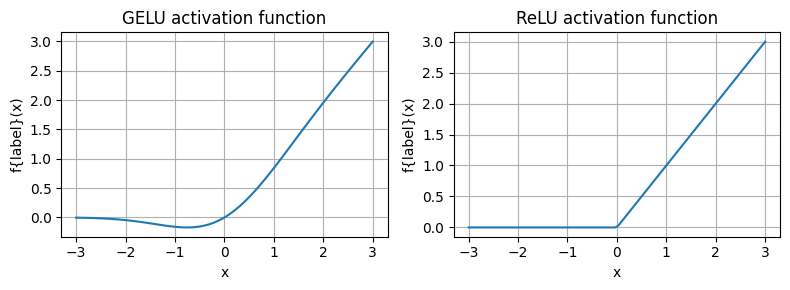

In [105]:
# Plot GELU vs ReLU
import matplotlib.pyplot as plt
gelu, relu = GELU(), nn.ReLU()

x = torch.linspace(-3, 3, 100)
y_gelu, y_relu = gelu(x), relu(x)
plt.figure(figsize=(8, 3))

for i, (y, label) in enumerate(zip([y_gelu, y_relu], ["GELU", "ReLU"]),1):
    plt.subplot(1, 2, i)
    plt.plot(x, y)
    plt.title(f"{label} activation function")
    plt.grid(True)
    plt.xlabel("x")
    plt.ylabel("f{label}(x)")
plt.tight_layout()
plt.show()

In [106]:
# Use GELU in feed forward network
class FeedForward(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(cfg["emb_dim"], 4 * cfg["emb_dim"]),
            GELU(),
            nn.Linear(4 * cfg["emb_dim"],cfg["emb_dim"]),
        )
    def forward(self, x):
        return self.layers(x)

In [107]:
# Test FFN
ffn = FeedForward(GPT_CONFIG_124M)
x = torch.rand(2, 3, 768)
out = ffn(x)
print(out.shape)

torch.Size([2, 3, 768])


In [108]:
# Shortcut connection (p 109) aka skip or residual connection (used to mitigate vanishing gradient problem)
class ExampleDeepNeuralNetwork(nn.Module):
    def __init__(self, layer_sizes, use_shortcut):
        super().__init__()
        self.use_shortcut = use_shortcut
    
        self.layers = nn.ModuleList([
            nn.Sequential(nn.Linear(layer_sizes[0],layer_sizes[1]),
                           nn.GELU()),
            nn.Sequential(nn.Linear(layer_sizes[1],layer_sizes[2]),
                            nn.GELU()),
            nn.Sequential(nn.Linear(layer_sizes[2],layer_sizes[3]),
                            nn.GELU()),
            nn.Sequential(nn.Linear(layer_sizes[3],layer_sizes[4]),
                            nn.GELU()),
            nn.Sequential(nn.Linear(layer_sizes[4],layer_sizes[5]),
                            nn.GELU())
        ])
    
    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
            if self.use_shortcut:
                x = x + x
        return x



In [109]:
layer_sizes = [3,3,3,3,3,1]
sample_input = torch.tensor([[1.,0.,-1.]])
torch.manual_seed(123)
model_without_shortcut = ExampleDeepNeuralNetwork(layer_sizes, use_shortcut=False)

In [110]:
# Create function that computes gradients in backwards pass
def print_gradients(model, x):

    output = model(x)
    target = torch.tensor([[0.]])

    loss = nn.MSELoss()
    loss = loss(output, target)

    loss.backward()

    for name, param in model.named_parameters():
        if 'weight' in name:
            print(f"{name} has gradient mean of {param.grad.abs().mean().item()}")



In [111]:
# Use the function to compute gradients
print_gradients(model_without_shortcut, sample_input)

layers.0.0.weight has gradient mean of 0.0002017411752603948
layers.1.0.weight has gradient mean of 0.00012011770741082728
layers.2.0.weight has gradient mean of 0.0007152436301112175
layers.3.0.weight has gradient mean of 0.0013988513965159655
layers.4.0.weight has gradient mean of 0.005049605388194323


In [112]:
# Compare by running with skip connections
torch.manual_seed(123)
model_with_shortcut = ExampleDeepNeuralNetwork(layer_sizes, use_shortcut=True)
print_gradients(model_with_shortcut, sample_input)

layers.0.0.weight has gradient mean of 0.00437004491686821
layers.1.0.weight has gradient mean of 0.0026738042943179607
layers.2.0.weight has gradient mean of 0.007288849912583828
layers.3.0.weight has gradient mean of 0.006180735770612955
layers.4.0.weight has gradient mean of 0.018918858841061592


In [113]:
# Create Transformer block class

class TransformerBlock(nn.Module):
    def __init__(self, cfg):
        super().__init__()

        self.att = MultiHeadAttention(
            d_in = cfg["emb_dim"], 
            d_out = cfg["emb_dim"], 
            context_length= cfg["context_length"], 
            dropout = cfg["drop_rate"],
            num_heads = cfg["n_heads"], 
            qkv_bias = cfg["qkv_bias"])

        self.ff = FeedForward(cfg)
        self.norm1 = LayerNorm(cfg["emb_dim"])
        self.norm2 = LayerNorm(cfg["emb_dim"])
        self.drop_shortcut = nn.Dropout(cfg["drop_rate"])

    def forward(self, x):

        shortcut = x
        x = self.norm1(x)
        x = self.att(x)
        x = self.drop_shortcut(x)
        x = x + shortcut

        shortcut = x
        x = self.norm2(x)
        x = self.att(x)
        x = self.drop_shortcut(x)
        x = x + shortcut
        
        return x

In [114]:
torch.manual_seed(123)
x = torch.rand(2, 4, 768)
block = TransformerBlock(GPT_CONFIG_124M)
out = block(x)
print("Input shape:", x.shape)
print("Output shape:", out.shape)

Input shape: torch.Size([2, 4, 768])
Output shape: torch.Size([2, 4, 768])


In [115]:
# Combined GPT model implementation (p119)
import torch.nn as nn

class GPTModel(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.tok_emb = nn.Embedding(cfg["vocab_size"], cfg["emb_dim"])
        self.pos_emb = nn.Embedding(cfg["context_length"], cfg["emb_dim"])
        self.drop_emb = nn.Dropout(cfg["drop_rate"])

        self.trf_blocks = nn.Sequential(
            *[TransformerBlock(cfg) for _ in range(cfg["n_layers"])])
        self.final_norm = LayerNorm(cfg["emb_dim"])
        self.out_head = nn.Linear(cfg["emb_dim"], cfg["vocab_size"], bias=False)

    def forward(self, in_idx):
        batch_size, seq_len = in_idx.shape
        tok_embeds = self.tok_emb(in_idx)
        pos_embeds = self.pos_emb(torch.arange(seq_len, device=in_idx.device))

        x = tok_embeds + pos_embeds
        x = self.drop_emb(x)
        x = self.trf_blocks(x)
        x = self.final_norm(x)
        logits = self.out_head(x)
        return logits

In [116]:
# Test the model

import torch

torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)

print(batch)
out = model(batch)
print("Input batch:\n", batch)
print("Output shape:\n", out.shape)
print(out)

tensor([[6109, 3626, 6100,  345],
        [6109, 1110, 6622,  257]])
Input batch:
 tensor([[6109, 3626, 6100,  345],
        [6109, 1110, 6622,  257]])
Output shape:
 torch.Size([2, 4, 50257])
tensor([[[ 0.3451, -0.1581,  0.1449,  ...,  0.3783,  0.2452, -0.0322],
         [ 0.7193, -0.5826, -0.8406,  ...,  0.0321,  0.4472,  0.1539],
         [ 0.4539, -0.4856, -0.0383,  ..., -0.0184,  0.0900,  0.3842],
         [-0.1530, -0.5794, -1.0264,  ...,  0.8591,  0.4963, -0.0424]],

        [[ 0.2897,  0.0633,  0.0743,  ...,  0.4048,  0.4094, -0.5518],
         [ 0.2448, -0.1063, -0.4019,  ...,  0.9687,  0.4392,  0.0090],
         [ 0.5637,  0.0404, -0.6694,  ...,  0.4882,  0.4269,  0.5272],
         [ 0.3791, -0.8584,  0.3340,  ...,  1.5315, -0.1680,  0.0020]]],
       grad_fn=<UnsafeViewBackward0>)


In [117]:
# Count params

total_params = sum(p.numel() for p in model.parameters())
print(f"Total number of parameters: {total_params:,}")

Total number of parameters: 163,009,536


In [118]:
# But the 163 mm figure above double counts the parameters in the output layer. 
# This is called weight tying and is a common technique in LLMs to reduce the number of parameters.
# SIG - reuses weights from embedding layer in output layer

print("Token embedding layer shape:", model.tok_emb.weight.shape)
print("Output layer shape:", model.out_head.weight.shape)

Token embedding layer shape: torch.Size([50257, 768])
Output layer shape: torch.Size([50257, 768])


In [119]:
# Remove output layer param count
total_params_gpt2 = (
    total_params - sum(p.numel()
                       for p in model.out_head.parameters())
)

print(f"Number of trainable params"
      f"considering weight tying: {total_params_gpt2:,}")

Number of trainable paramsconsidering weight tying: 124,412,160


In [120]:
# Calculate total size of model
total_size_bytes = total_params * 4
total_size_mb = total_size_bytes / (1024 * 1024)
print(f"Total size of the model: {total_size_mb:.2f} MB")

Total size of the model: 621.83 MB


In [121]:
# Create function to generate text

def generate_text_simple(model,idx,max_new_tokens, context_size):
    for _ in range(max_new_tokens):
        idx_cond = idx[:,-context_size:] # Crops context if too large
        with torch.no_grad():
            logits = model(idx_cond)
        logits = logits[:,-1, :]  # Focus on last time step
        probas = torch.softmax(logits, dim=-1)  # Shape is (batch, vocab_size)
        idx_next = torch.argmax(probas, dim=-1,keepdim=True)  # Shape (batch, 1)
        idx = torch.cat((idx, idx_next),dim=1)  # Appends newest work, idx shape (batch, n_tokens + 1)
    return idx

In [122]:
start_context = "Hello, I am"
encoded = tokenizer.encode(start_context)
print("encoded:",encoded)
encoded_tensor = torch.tensor(encoded).unsqueeze(0)
print("encoded_tensor.shape: ",encoded_tensor.shape)


encoded: [15496, 11, 314, 716]
encoded_tensor.shape:  torch.Size([1, 4])


In [123]:
# eval mode disables random components

model.eval()
out = generate_text_simple(
    model=model,
    idx = encoded_tensor,
    max_new_tokens=6,
    context_size = GPT_CONFIG_124M['context_length']
)
print("Output:", out)
print("Output length:", len(out[0]))

Output: tensor([[15496,    11,   314,   716, 13008, 36543,  9859, 37516,  4397, 38808]])
Output length: 10


In [124]:
# Convert IDs back to text using decoder
decoded_text = tokenizer.decode(out.squeeze(0).tolist())
print(decoded_text)

Hello, I am wallet sarcast drew eightysey Nay


In [125]:
# Produces gibberish because using random initial weights and no training (yet)

In [126]:
# Ch 5 Pretraining on unlabeled data (p128)

In [133]:
import torch

GPT_CONFIG_124M = {
    "vocab_size": 50257,  # Same as BPE vocab size
    "context_length": 256, # Changed from 1024 in earlier model
    "emb_dim": 768, # Embedding size for each token
    "n_heads": 12,  # Num of attention heads in each multi-head attention layer
    "n_layers": 12, # Num of transformer blocks
    "drop_rate": 0.1,  # 0.1 means 10% dropped
    "qkv_bias": False    # Whether to add a learnable bias to the query, key, and value projections
}

torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)
model.eval()

GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(256, 768)
  (drop_emb): Dropout(p=0.1, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=False)
        (W_key): Linear(in_features=768, out_features=768, bias=False)
        (W_value): Linear(in_features=768, out_features=768, bias=False)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.1, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features

In [131]:
# Create utility functions fpr text to token ID conversions

import tiktoken

def text_to_token_ids(text, tokenizer):
    encoded = tokenizer.encode(text, allowed_special={'<|endoftext|'})
    encoded_tensor = torch.tensor(encoded).unsqueeze(0)  # Unsqueeze adds batch dimension
    return encoded_tensor

def token_ids_to_text(token_ids,tokenizer):
    flat = token_ids.squeeze(0)  # Removes batch dimension
    return tokenizer.decode(flat.tolist())

start_context = "Every effort moves you"
tokenizer = tiktoken.get_encoding("gpt2")

token_ids = generate_text_simple(
    model=model,
    idx = text_to_token_ids(start_context,tokenizer),
    max_new_tokens=10,
    context_size=  GPT_CONFIG_124M['context_length']

)

print("Output text:\n", token_ids_to_text(token_ids,tokenizer))




Output text:
 Every effort moves you rentingFactor maintenance appraisal appropriation�� Tehran Burn issuerilibrium


In [137]:
# p 133 examples

inputs = torch.tensor([[16833,3626, 6100],
                       [40,1107,588]])

targets = torch.tensor([[3626,6100,345],
                        [1107,588,11311]])

In [136]:
# Create logits, convert into prob scores
import torch
with torch.no_grad():
    logits = model(inputs)
probas = torch.softmax(logits, dim=-1)
print(probas.shape)



torch.Size([2, 3, 50257])


In [138]:
# Get token IDs using argmax
token_ids = torch.argmax(probas,dim=-1,keepdim=True)
print("Token IDs:\n",token_ids)

Token IDs:
 tensor([[[16657],
         [45647],
         [ 1804]],

        [[49906],
         [15335],
         [20861]]])


In [139]:
# Convert token ids back to text
print(f"Targets batch 1:{token_ids_to_text(targets[0],tokenizer)}")
print(f"Outputs batch 1:"
      f"{token_ids_to_text(token_ids[0].flatten(),tokenizer)}")

Targets batch 1: effort moves you
Outputs batch 1: Armed sd doing


In [141]:
# Get initial softmax prob scores corresp to target tokens
text_idx = 0
target_probas_1 = probas[text_idx,[0,1,2],targets[text_idx]]
print("Text 1:",target_probas_1)

text_idx=1
target_probas_2 = probas[text_idx,[0,1,2],targets[text_idx]]
print("Text 2:",target_probas_2)

Text 1: tensor([    0.0001,     0.0000,     0.0000])
Text 2: tensor([    0.0000,     0.0000,     0.0000])


In [142]:
# Need to convert target probas to log
log_probas = torch.log(torch.cat((target_probas_1,target_probas_2)))
print(log_probas)

tensor([ -9.2727, -10.4829, -10.8902, -11.3943, -10.0409, -12.0300])


In [143]:
# Get avg of log probas
avg_log_probas = torch.mean(log_probas)
print((avg_log_probas))

tensor(-10.6852)


In [144]:
neg_avg_log_probas = avg_log_probas * -1
print(neg_avg_log_probas)

tensor(10.6852)


In [145]:
# Avg neg log loss is similar to cross-entropy and used interchangeably

# CHeck shape of logitsand targets

print("Logits shape: ",logits.shape)
print("Targets shape:", targets.shape)

Logits shape:  torch.Size([2, 3, 50257])
Targets shape: torch.Size([2, 3])


In [147]:
# For cross entropy need to flatten tensors by combining over batch dimension

logits_flat = logits.flatten(0,1)
targets_flat = targets.flatten(0,1)
print("Flattened logits:", logits_flat.shape)
print("Flattened targets:,", targets_flat.shape)


Flattened logits: torch.Size([6, 50257])
Flattened targets:, torch.Size([6])


In [151]:
# use cross entropy function
# In one step this applies softmax, selects prob score corresp to target id, and compute neg avg log prob

loss = torch.nn.functional.cross_entropy(logits_flat,targets_flat)
print(loss)

tensor(10.6852)


In [152]:
# Perplexity (p 139) -  how well does model's prob dist match actual prob dist
perplexity = torch.exp(loss)
print(perplexity)

tensor(43702.9180)


In [155]:
# Reuse text from The Verdict

file_path = "the-verdict.txt"
with open(file_path, "r", encoding='utf-8') as file:
    text_data = file.read()

total_characters = len(text_data)
total_tokens = len(tokenizer.encode(text_data))
print("Characters:", total_characters)
print("Tokens:", total_tokens)

Characters: 20479
Tokens: 5145


In [156]:
# Split data into training and validation sets
train_ratio = 0.90
split_index = int(train_ratio * len(text_data))
train_data = text_data[:split_index]
val_data = text_data[split_index:]

In [157]:
# Create dataloaders

train_loader = create_dataloader_v1(
    train_data,
    batch_size=2,
    max_length=GPT_CONFIG_124M["context_length"],
    stride=GPT_CONFIG_124M["context_length"],
    drop_last=True,
    shuffle=True,
    num_workers=0
)

val_loader = create_dataloader_v1(
    val_data,
    batch_size=2,
    max_length=GPT_CONFIG_124M["context_length"],
    stride=GPT_CONFIG_124M["context_length"],
    drop_last=False,
    shuffle=False,
    num_workers=0
)


In [159]:
# Confirm dataloaders created correctly

print("Train loader:")
for x,y in train_loader:
    print(x.shape,y.shape)

print("\nValidation loader:")
for x,y in val_loader:
    print(x.shape,y.shape)

Train loader:
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])

Validation loader:
torch.Size([2, 256]) torch.Size([2, 256])


In [ ]:
# Utility function to calculate cross entropy loss for a given batch

def calc_loss_batch(input_batch,target_batch, model, device):
    input_batch = input_batch.to(device)
    target_batch = target_batch.to(device)
    logits = model(input_batch)
    loss = torch.nn.functional.cross_entropy(
        logits.flatten(0,1),target_batch.flatten()  
    )
    return loss

In [165]:
# Create function to compute loss for all batchs in dataloader rather than just one

def calc_loss_loader(data_loader, model, device, num_batches=None):
    total_loss = 0.
    if len(data_loader) == 0:
        return float("nan")
    elif num_batches is None:
        num_batches = len(data_loader)
    else:
        num_batches = min(num_batches, len(data_loader))
    for i, (input_batch, target_batch) in enumerate(data_loader):
        if i < num_batches:
            loss = calc_loss_batch(
                input_batch,target_batch, model, device
            )
            total_loss += loss.item()
        else:
            break
    return total_loss / num_batches

In [166]:
# Apply this function to training and validation loaders

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
with torch.no_grad():
    train_loss = calc_loss_loader(train_loader,model,device)
    val_loss = calc_loss_loader(val_loader,model,device)
print("Training loss:", train_loss)
print("Validation loss:",val_loss)

Training loss: 10.990534146626791
Validation loss: 10.977392196655273
